In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa
import librosa.display
import noisereduce as nr 
from tqdm import tqdm



In [13]:
metadata_df = pd.read_csv('../Train.csv')
print(metadata_df.head())

              id     audio_filepath  duration class
0  id_6nazjwygdl  id_6nazjwygdl.wav     1.984  left
1  id_jpwl97yilf  id_jpwl97yilf.wav     2.027  down
2  id_9d131fb32p  id_9d131fb32p.wav     2.274    go
3  id_kat2oty4s0  id_kat2oty4s0.wav     2.176  down
4  id_g3hvae3jbe  id_g3hvae3jbe.wav     1.634  down


In [14]:
print(metadata_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5334 entries, 0 to 5333
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              5334 non-null   object 
 1   audio_filepath  5334 non-null   object 
 2   duration        5334 non-null   float64
 3   class           5334 non-null   object 
dtypes: float64(1), object(3)
memory usage: 166.8+ KB
None


In [15]:
print(metadata_df.isnull().sum())



id                0
audio_filepath    0
duration          0
class             0
dtype: int64


class
go       759
down     665
stop     655
left     651
right    651
up       651
yes      651
no       651
Name: count, dtype: int64


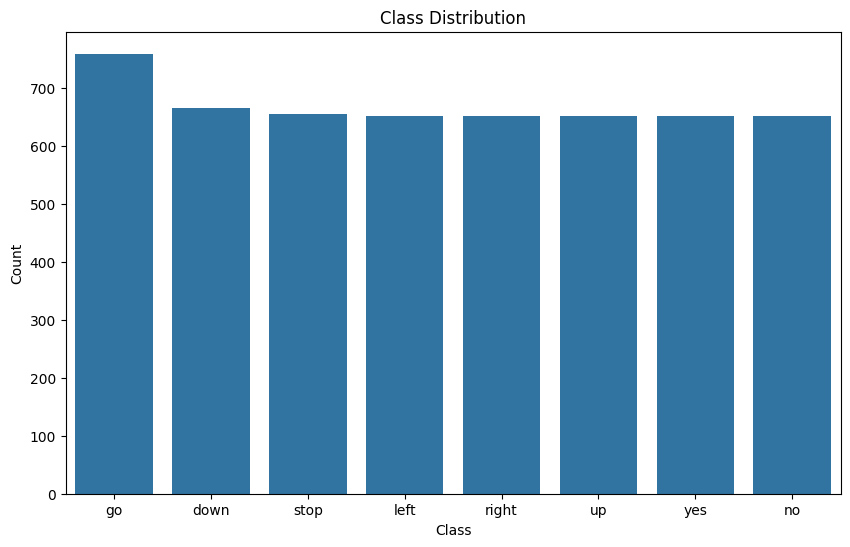

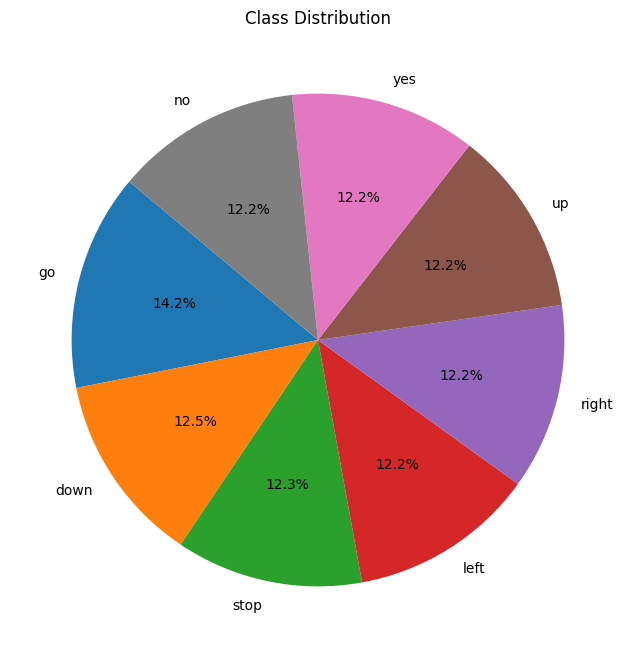

In [16]:
class_counts = metadata_df['class'].value_counts()
print(class_counts)

# class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.show()

In [17]:
print(metadata_df.describe())

          duration
count  5334.000000
mean      1.844375
std       0.436861
min       1.077833
25%       1.554000
50%       1.899000
75%       2.133000
max       2.998000


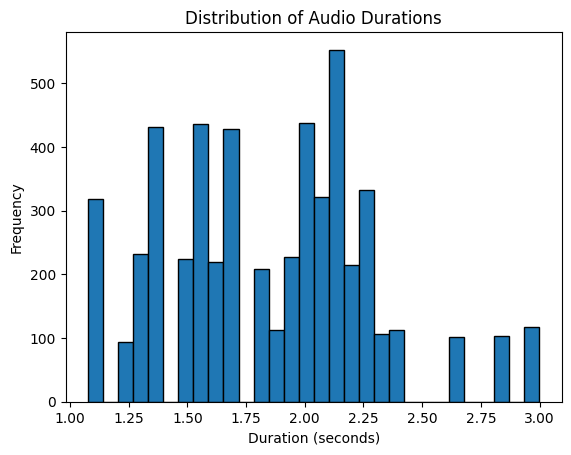

max duration: 2.998
min duration: 1.0778333333333334


In [18]:
# Distrubution of audio duration showing the minimum, maxiumum, mean, median, std   
plt.hist(metadata_df['duration'], bins=30, edgecolor='black')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Audio Durations')
plt.show()

# max duration
print('max duration:', metadata_df['duration'].max())

# min duration
print('min duration:', metadata_df['duration'].min())


y shape: (43748,)
sr: 22050


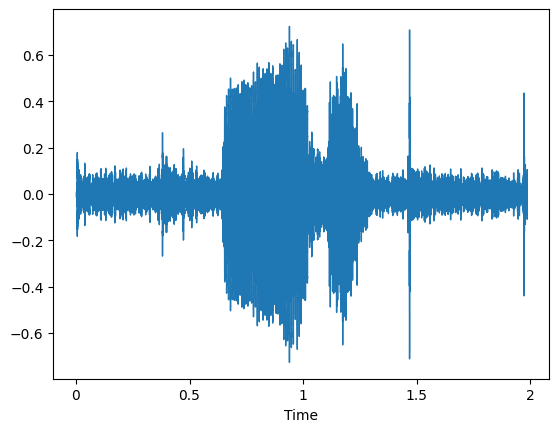

In [19]:
root_path = "../TechCabal Ewe Audio Files/"
audio_path = root_path + metadata_df.iloc[0, 1]

y, sr = librosa.load(audio_path, mono=True)
print('y shape:', y.shape)
print('sr:', sr)
print(librosa.display.waveshow(y, sr=sr))
ipd.Audio(y, rate=sr)

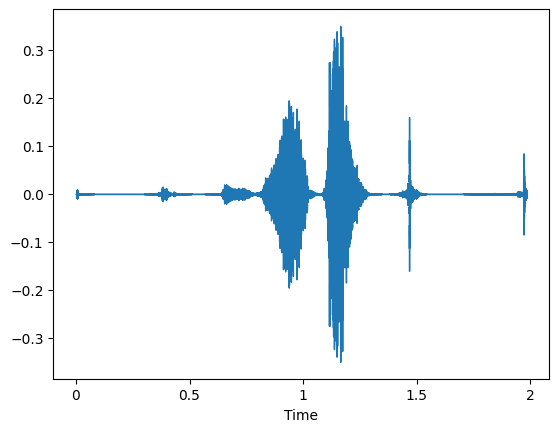

In [20]:
def denoise(sig, sr, threshold=2.0, is_stationary=True):
    return nr.reduce_noise(y=sig, sr=sr, n_std_thresh_stationary=threshold, stationary=is_stationary)

denoised_y = denoise(y, sr)

print(librosa.display.waveshow(denoised_y, sr=sr))
ipd.Audio(denoised_y, rate=sr)

(13, 86)


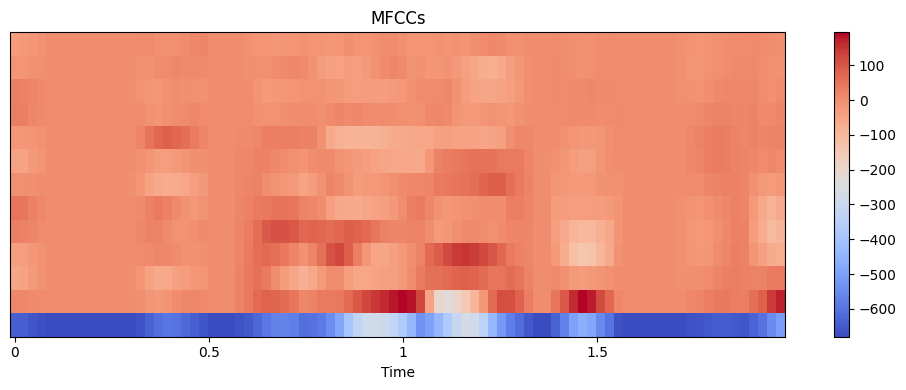

In [21]:
mfcc = librosa.feature.mfcc(y=denoised_y, sr=sr, n_mfcc=13)
print(mfcc.shape)

# plotting the mfccs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCCs')
plt.tight_layout()
plt.show()


  0%|          | 0/5334 [00:00<?, ?it/s]

100%|██████████| 5334/5334 [03:44<00:00, 23.78it/s]


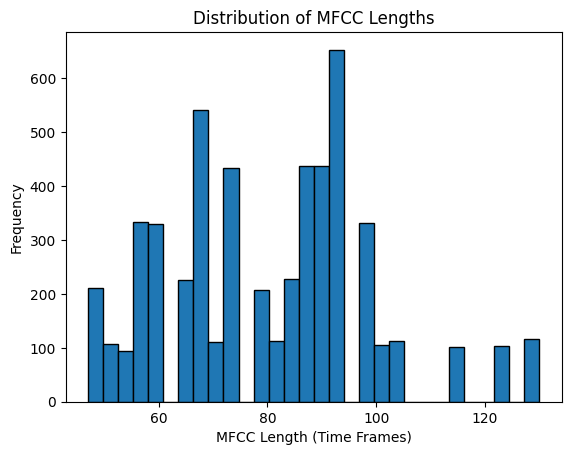

min of mfcc lengths: 47
mean of mfcc lengths: 79.90007499062617
median of mfcc lengths: 82.0
std of mfcc lengths: 18.780777714006756
max of mfcc lengths: 130


In [22]:
# check the distribution of mfcc lengths
mfcc_lengths = []

for idx in tqdm(range(len(metadata_df))):
    audio_path = root_path + metadata_df.loc[idx, 'audio_filepath']
    y, sr = librosa.load(audio_path, mono=True)
    denoised_y = denoise(y, sr)
    mfcc = librosa.feature.mfcc(y=denoised_y, sr=sr, n_mfcc=13)
    mfcc_lengths.append(mfcc.shape[1])

plt.hist(mfcc_lengths, bins=30, edgecolor='black')
plt.xlabel('MFCC Length (Time Frames)')
plt.ylabel('Frequency')
plt.title('Distribution of MFCC Lengths')
plt.show()


print('min of mfcc lengths:', np.min(mfcc_lengths))
print('mean of mfcc lengths:', np.mean(mfcc_lengths))
print('median of mfcc lengths:', np.median(mfcc_lengths))
print('std of mfcc lengths:', np.std(mfcc_lengths))
print('max of mfcc lengths:', np.max(mfcc_lengths))

In [23]:
unique_classes = metadata_df['class'].unique()
class_mapping = {class_name: idx for idx, class_name in enumerate(unique_classes)}

metadata_df['classID'] = metadata_df['class'].map(class_mapping)
print(metadata_df.head())

              id     audio_filepath  duration class  classID
0  id_6nazjwygdl  id_6nazjwygdl.wav     1.984  left        0
1  id_jpwl97yilf  id_jpwl97yilf.wav     2.027  down        1
2  id_9d131fb32p  id_9d131fb32p.wav     2.274    go        2
3  id_kat2oty4s0  id_kat2oty4s0.wav     2.176  down        1
4  id_g3hvae3jbe  id_g3hvae3jbe.wav     1.634  down        1


In [24]:
target_mfcc_length = int(np.percentile(mfcc_lengths, 95))
print('target mfcc length:', target_mfcc_length)


target mfcc length: 115


In [25]:
def preprocess_audio(file_path, max_length, max_duration):
    sig ,sr = librosa.load(file_path, duration=max_duration)
    sig = denoise(sig, sr)
    mfcc = librosa.feature.mfcc(y=sig, sr=sr, n_mfcc=40)
    if mfcc.shape[1] > max_length:
        mfcc = mfcc[:,:max_length]
    else:
        pad_width = max_length - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0,0), (0, pad_width)), mode='constant')
    return mfcc

extracted_features = []
target_mfcc_length = int(np.percentile(mfcc_lengths, 95))
max_audio_duration = metadata_df['duration'].max()

for idx in tqdm(range(len(metadata_df))):
    audio_path = root_path + metadata_df.loc[idx, 'audio_filepath']
    features = preprocess_audio(audio_path, target_mfcc_length, max_audio_duration)
    label = metadata_df.loc[idx, 'classID']
    extracted_features.append([features, label])

100%|██████████| 5334/5334 [03:34<00:00, 24.88it/s]


In [30]:
extracted_features_df = pd.DataFrame(extracted_features, columns=['features', 'label']
                                     )
extracted_features_df.head()


,features,label
0,"[[-639.0543, -643.1824, -659.52325, -671.4832,...",0
1,"[[-661.11523, -661.11523, -661.11523, -661.115...",1
2,"[[-587.7073, -587.7073, -587.7073, -587.7073, ...",2
3,"[[-684.55176, -684.25665, -684.3939, -684.5517...",1
4,"[[-591.0684, -589.1622, -587.2223, -584.7621, ...",1


In [34]:
extracted_features_df.loc[0, 'features']
extracted_features_df.loc[0, 'features'].shape

(40, 115)

In [35]:

features = extracted_features_df['features'].tolist()
labels = extracted_features_df['label'].tolist()

In [39]:
print(len(features))
print(len(labels))


5334
5334


In [40]:
# save features and labels separately
np.save('features.npy', features)
np.save('labels.npy', labels)


In [41]:
#load features and labels
features = np.load('features.npy')
labels = np.load('labels.npy')

print(features.shape)
print(labels.shape)

(5334, 40, 115)
(5334,)
